# Воронка событий и A/A/B-тест на примере данных приложения e-commerce

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
<br>
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.
<br>
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
<br>
<br>
План проекта:
<br>
1 Предобработка данных
<br>
2 Изучение данных
<br>
3 Изучение воронки событий
<br>
4 Проведение и изучение результатов эксперимента
<br>
5 Общий вывод
<br>
<br>
Описание данных
<br>
EventName — название события;
<br>Изучение результатов эксперимента
DeviceIDHash — уникальный идентификатор пользователя;
<br>
EventTimestamp — время события;
<br>
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
<br>


## Предобработка данных

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
from scipy import stats as st
import math as mth

import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go

import datetime as dt

In [2]:
url = 'https://drive.google.com/file/d/1dswUbdRhrtNuaYN7ZHVd7mU-UPYxo-bo/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
data = pd.read_csv(path, sep='\t')

data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


Посмотрим о каких операциях у нас есть данные:

In [3]:
data['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Будем считать, что:
<br>
'MainScreenAppear' — "Главвный экран"
<br>
'PaymentScreenSuccessful' — "Оплата совершена"
<br>
'CartScreenAppear' — "Окно Корзины"
<br>
'OffersScreenAppear' — "Рекомендации"
<br>
'Tutorial' — "Руководство"

Заменим названия столбцов:

In [4]:
data_columns = ['event_name', 'user_id', 'timestamp', 'group_id']
data.columns = data_columns
data.head(5)

,event_name,user_id,timestamp,group_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Добавим столбцы с временем и датой:

In [5]:
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['datetime'].dt.date
data['date'] = data['date'].astype('datetime64')

data.head(5)

,event_name,user_id,timestamp,group_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Проверим данные на наличие пропусков:

In [6]:
data.isna().sum()

event_name    0
user_id       0
timestamp     0
group_id      0
datetime      0
date          0
dtype: int64

Проверим данные на наличие дубликатов:

In [7]:
data.duplicated().sum()

413

In [8]:
data = data.drop_duplicates().reset_index(drop=True)
data

,event_name,user_id,timestamp,group_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Итак, в данных не было обнаружено пропусков, но были обнаружены дубликаты — мы избавились от них. Мы также переименовали названия столбцов и добавили столбцы с временем и датой для дальшейших вычеслений.

## Изучение данных

Узнаем сколько всего событий в логе, cколько всего пользователей в логе и сколько в среднем событий приходится на пользователя:

In [9]:
print('Число  событий: 243713')
print('Число уникальных событий:')

data_per_event = data.groupby('event_name').agg({'user_id':'count'}).reset_index()

data_per_event

Число  событий: 243713
Число уникальных событий:


,event_name,user_id
0,CartScreenAppear,42668
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


In [10]:
print('Число уникальных пользователей:', data['user_id'].nunique())

Число уникальных пользователей: 7551


In [11]:
print('Среднее число событий на одного пользователя:', round(data['event_name'].count() / data['user_id'].nunique()))

Среднее число событий на одного пользователя: 32


Посмотрим на распределение событий поближе:

In [12]:
event_count = data.groupby('event_name').agg({'event_name':'count'})
event_count.columns = ['event_count']
event_count = event_count.reset_index()

event_by_users = data.groupby('user_id').agg({'event_name':'count'})

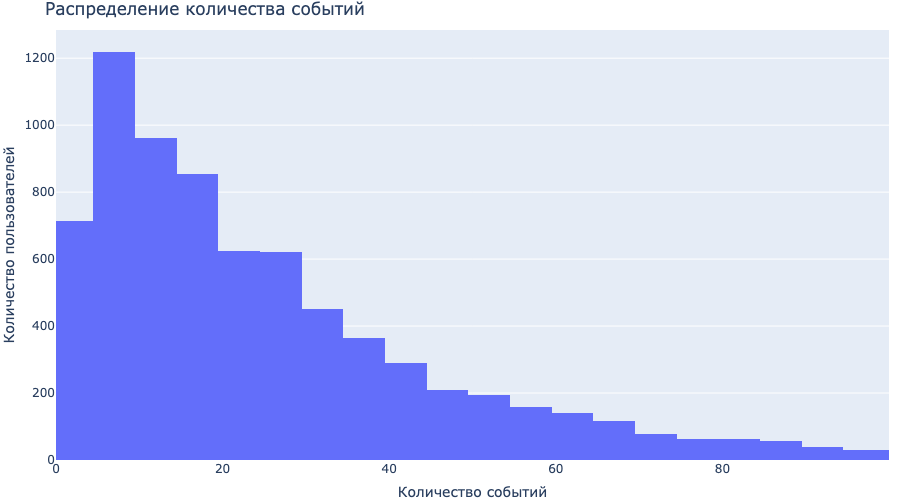

In [13]:
fig=px.histogram(event_by_users, x="event_name")

fig.update_layout(title='Распределение количества событий',
                  xaxis_title="Количество событий",
                  yaxis_title="Количество пользователей",
                  margin=dict(l=0, r=0, t=30, b=0),
                  width=900,
                  height=500)
fig.update_xaxes(range=[0, 100])

fig.show('png')

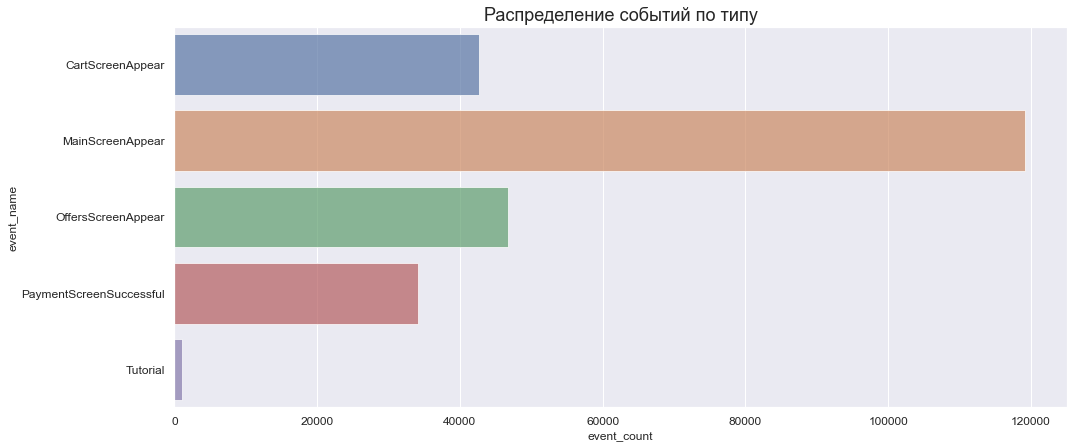

In [14]:
fig = plt.figure(figsize=(16, 7))

sns.set(style='darkgrid')

sns.barplot(y='event_name', x='event_count', data=event_count, alpha = 0.7)

plt.title('Распределение событий по типу', fontsize=(18))
plt.xticks(fontsize=(12))
plt.yticks(fontsize=(12))

plt.show()

Узнаем данными за какой период мы располагаем:

In [15]:
print('Самая ранняя дата:', data['datetime'].min())
print('Самая поздняя дата:', data['datetime'].max())

Самая ранняя дата: 2019-07-25 04:43:36
Самая поздняя дата: 2019-08-07 21:15:17


Построим гистограмму с пользовательской активностью за исследуемый период:

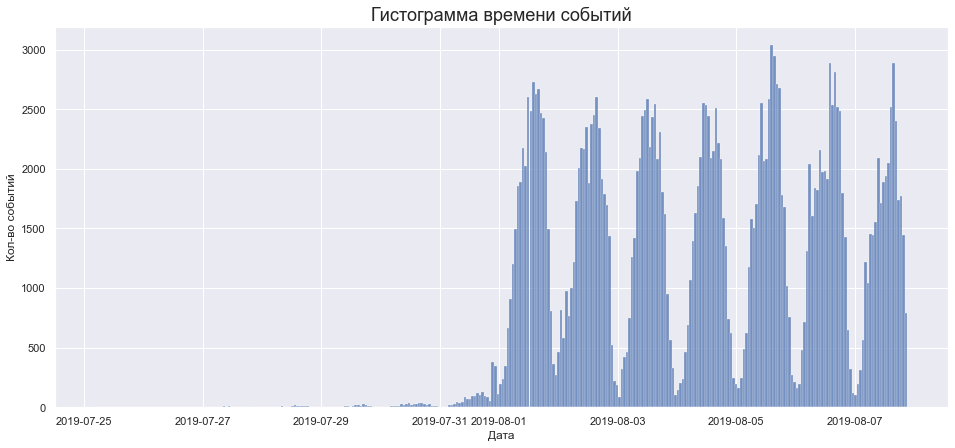

In [16]:
plt.figure(figsize=(16,7))

sns.set(style='darkgrid')

sns.histplot(data=data, x='datetime', bins=320)
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.title('Гистограмма времени событий', fontsize=(18))

plt.show()

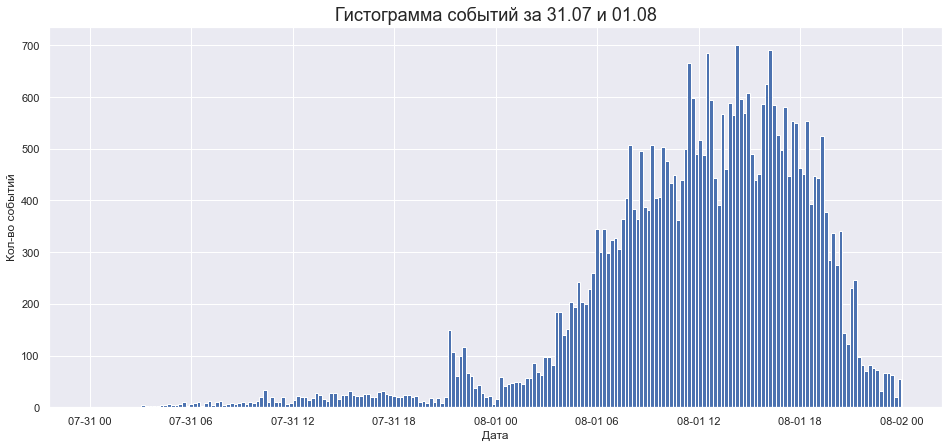

In [17]:
plt.figure(figsize=(16,7))

sns.set(style='darkgrid')

plt.hist(data=data, x='datetime', bins=220, range=('2019-07-31 00:00:00','2019-08-01 23:59:00'))
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.title('Гистограмма событий за 31.07 и 01.08', fontsize=(18))

plt.show()

Итак, дата начала сбора данных — 25 июля 2019, дата окончания - 7 августа 2019. Похоже, что мы обладаем данными за 2 недели. Но гистограмма показывает, что до конца июля в приложении практически не происходит активности — она начинаются только с 31 июля (примерно в 5 часов утра), и имеет весьма периодичный повторяющийся характер: пик приходится на день, затем ночью следует спад.

Отбросим первую "пассивную" неделю и посмотрим на "очищенные" данные:

In [18]:
data_active = data.query('date > "2019-07-30"').reset_index(drop=True)
data_active.head(5)

,event_name,user_id,timestamp,group_id,datetime,date
0,MainScreenAppear,3670880358399219515,1564535506,247,2019-07-31 01:11:46,2019-07-31
1,OffersScreenAppear,3799109751993694887,1564536064,248,2019-07-31 01:21:04,2019-07-31
2,Tutorial,1126021718529336913,1564536731,247,2019-07-31 01:32:11,2019-07-31
3,MainScreenAppear,4293428370257583636,1564539558,248,2019-07-31 02:19:18,2019-07-31
4,MainScreenAppear,4567464647598975872,1564540410,247,2019-07-31 02:33:30,2019-07-31


In [19]:

print('Потеря в пользователях:', round((data['user_id'].nunique() - data_active['user_id'].nunique()) / data['user_id'].nunique(), 3) * 100, '%')

print('Потеря в событиях:', round((data['event_name'].count() - data_active['event_name'].count()) / data['event_name'].count(), 3) *100, '%')




Потеря в пользователях: 0.1 %
Потеря в событиях: 0.3 %


In [20]:
data_active.groupby('group_id')['user_id'].nunique()

group_id
246    2485
247    2517
248    2540
Name: user_id, dtype: int64

Мы потеряли совершенно незначительное кол-во данных, и все пользователи из групп A, A и B на месте.

## Изучение воронки событий

Посмотрим какие события встречаются чаще всего:

In [21]:
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [22]:
data_events = data.groupby('event_name').agg({'user_id':'count'}).reset_index()
data_events = data_events.query('event_name != "Tutorial"')
data_events.sort_values(by='user_id', ascending=False)

,event_name,user_id
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
0,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118


Мы уже предположили, что названия событий переводятся так:
<br>
'MainScreenAppear' — "Главвный экран"
<br>
'PaymentScreenSuccessful' — "Оплата совешена"
<br>
'CartScreenAppear' — "Окно Корзины"
<br>
'OffersScreenAppear' — "Рекомендации"
<br>
'Tutorial' — "Руководство"
<br>
<br>
Последовательность такая: "Руководство", "Главвный экран", "Рекомендации", "Окно Корзины", "Оплата совершена". "Руководство" вряд ли стоит учитывать при расчете воронки, а этап 'MainScreenAppear' становится самым популярным.

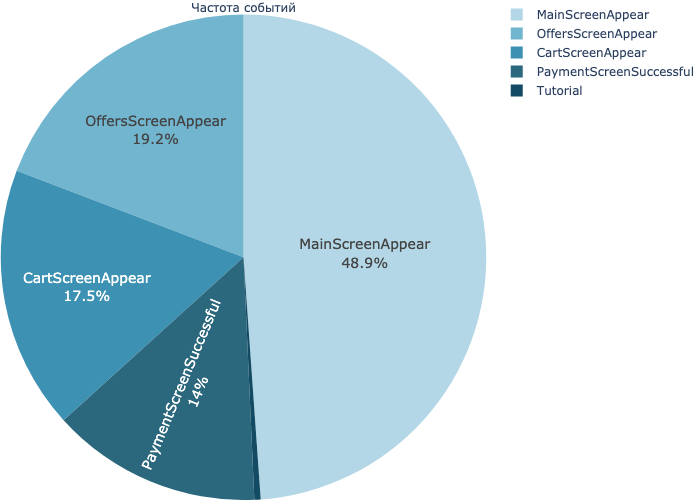

In [23]:
colors = ['#B3D7E6', '#72B5CF', '#3D91B3', '#2B677D', '#124B63']

fig = go.Figure(data=[go.Pie(labels=data['event_name'].value_counts().index, marker=dict(colors=colors), values=data['event_name'].value_counts(), textinfo='label+percent', title='Частота событий')])

fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=14, uniformtext_mode='hide', margin=dict(l=0, r=0, b=0, t=0))
fig.show('png')


Посчитаем сколько пользователей совершали каждое из этих событий, а также долю пользователей, которые хоть раз совершали какое-либо событие:

In [24]:
users_event = data_active.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
users_event.columns = ['events', 'unique_users']
users_event = users_event.reset_index()

users_event['share'] = round((users_event['unique_users'] / data_active['user_id'].nunique()) * 100)
users_event = users_event.query('event_name != "Tutorial"')

users_event

,event_name,events,unique_users,share
0,MainScreenAppear,118578,7429,99.0
1,OffersScreenAppear,46707,4606,61.0
2,CartScreenAppear,42560,3742,50.0
3,PaymentScreenSuccessful,34058,3542,47.0


Построим воронку:

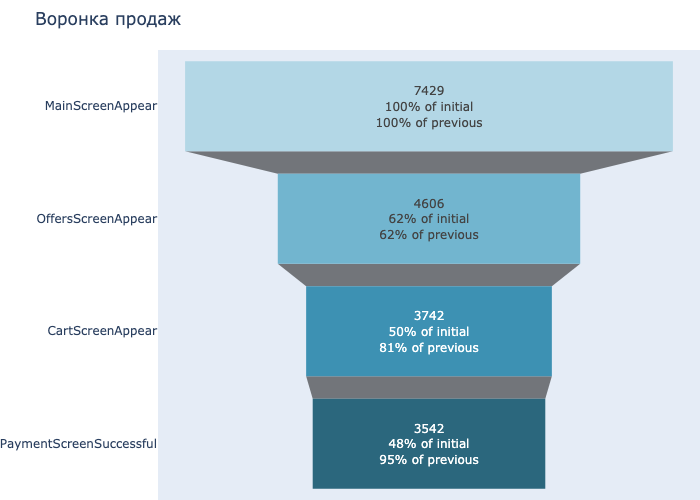

In [25]:
fig = go.Figure(go.Funnel(x=users_event['unique_users'], y=users_event['event_name'], textinfo="value+percent initial+percent previous", marker={"color": ['#B3D7E6', '#72B5CF', '#3D91B3', '#2B677D', '#124B63']}))

fig.update_layout(title='Воронка продаж', margin=dict(l=0, r=0, t=50, b=0))

fig.show('png')


Итак, воронка выглядит неплохо: 48% пользователей, в итоге, оплачивают товар, причем почти всем нравятся предложенные товары и с оплатой проблем не возникает. Но до предложенных товаров доходят далеко не все — только 62% пользователей. Потеря в 40% уже на первом этапе воронки ("Главный экран") сведетельствует о серьезной проблеме в приложении. Раздел с руководством о том как пользоваться приложением, скорее всего, просто пролистывают, и в воронке продаж этот этап не учавствует.

## Изучение результатов эксперимента

Еще раз посмотрим на количество пользователей в каждой группе:

In [26]:
data_groups = data_active.groupby('group_id')['user_id'].nunique()
data_groups['246+247'] = data_groups[246] + data_groups[247]
data_groups

group_id
246        2485
247        2517
248        2540
246+247    5002
Name: user_id, dtype: int64

In [27]:
data_groups_events = data_active.pivot_table(index='event_name', columns='group_id', values='user_id', aggfunc='nunique')
data_groups_events = data_groups_events.reset_index()

data_groups_events['246+247'] = data_groups_events[246] + data_groups_events[247]
data_groups_events['share_246'] = round((data_groups_events[246] / data_groups[246]) * 100)
data_groups_events['share_247'] = round((data_groups_events[247] / data_groups[247]) * 100)
data_groups_events['share_248'] = round((data_groups_events[248] / data_groups[248]) * 100)
data_groups_events['share_246+247'] = round(((data_groups_events[246] + data_groups_events[247]) / (data_groups[246] + data_groups[247])) * 100)
data_groups_events = data_groups_events.query('event_name != "Tutorial"')

data_groups_events

group_id,event_name,246,247,248,246+247,share_246,share_247,share_248,share_246+247
0,CartScreenAppear,1267,1239,1236,2506,51.0,49.0,49.0,50.0
1,MainScreenAppear,2452,2479,2498,4931,99.0,98.0,98.0,99.0
2,OffersScreenAppear,1544,1526,1536,3070,62.0,61.0,60.0,61.0
3,PaymentScreenSuccessful,1200,1159,1183,2359,48.0,46.0,47.0,47.0


Прведем z-тест для сравнения долей наших групп по всем событиям: 246, 247 и 248. 
<br>
Сформулируем гипотезы:
<br>
H0 - "Группы равны"
<br>
H1 - "Группы не равны"
 

In [28]:
# Напишем функцию:
alpha = 0.05
alpha_bonferroni = 0.05 / 16

def z_test(group_1, group_2, alpha):
    for i in data_groups_events.index:
        p1 = data_groups_events[group_1][i] / data_groups[group_1]
        p2 = data_groups_events[group_2][i] / data_groups[group_2]
        
        p_combined = ((data_groups_events[group_1][i] + data_groups_events[group_2][i]) / (data_groups[group_1] + data_groups[group_2]))
        difference = p1 - p2

        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/data_groups[group_1] + 1/data_groups[group_2]))

        distr = st.norm(0, 1) 
        
        p_value = round((1 - distr.cdf(abs(z_value))) * 2, 2)
        
        print('{} p-значение: {}'.format(data_groups_events['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
            print('')


In [29]:
# 246 и 247:
z_test(246, 247, alpha_bonferroni)

CartScreenAppear p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.59
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.27
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Группы 246 и 247 — это наши 2 контрольные группы для А/А-эксперимента выше. Как видим, разницы между контрольными группами нет, они разделены корректно.

In [30]:
# 246 и 248:
z_test(246, 248, alpha_bonferroni)

CartScreenAppear p-значение: 0.1
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.34
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Группа 248 — это наша группа с измененным шрифтом. Z-тест не выявил разницу между контрольной группой и эксперементальной.

In [31]:
# 247 и 248:
z_test(247, 248, alpha_bonferroni)

CartScreenAppear p-значение: 0.69
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.68
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.91
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.71
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Как и ожидалось, разницы нет и между второй контрольной группой и эксперементальной.

In [32]:
# 246 + 247 и 248:
z_test('246+247', 248, alpha_bonferroni)

CartScreenAppear p-значение: 0.24
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.45
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.63
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Такие же выводы и с объединённой контрольной группой.

Итак, для всех групп и по всем событиям разница выборок не значительна при параметре alpha = 0.05. Применив поправку Бонферонни дабы избежать ошибки первого рода (получить значимые различия там, где их нет), мы уменьшили значение alpha пропорционально числу проверяемых гипотез (16). Мы получили такие же выводы, и тем самым еще раз подтвердили прежний результат.

## Общий вывод

Анализ данных о продажах в приложении мы начали с предобработки: избавились от дубликатов, переименовали столбцы, добавили дополнительные столбцы с временем и датой, — на их основе был проанализирован период, за который были собраны данные.
<br>
<br>
Мы пришли к следующим выводам:
   - мы обладаем данными за 2 недели (25 июля - 7 августа 2019), но, при более подробном рассмотрении, гистограмма показала, что до конца июля в приложении практически не происходит активности — она начинаются только с 31 июля;
   - отбросив первую "пассивную" неделю, мы обнаружили, что потеряли совершенно незначительное кол-во данных, и все пользователи из групп 246, 247 и 248 на месте;
   - самое часто встречающееся событие 'MainScreenAppear' — "Главный экран";
   - построив воронку продаж по этапам, мы увидели, что 48% пользователей, в итоге, оплачивают товар, причем почти всем нравятся предложенные товары и с оплатой проблем не возникает, но до предложенных товаров доходят далеко не все — только 62% пользователей;
   - потеря в 40% уже на первом этапе воронки ("Главный экран") сведетельствует о серьезной проблеме в приложении.
 
<br>
Нами также был проведен z-тест чтобы узнать есть ли разница в пропорциях наших групп и является ли она статистически значимой. Мы сравнивали и контрольные группы 246 и 247 между собой (А/А-тест), и каждую из контрольный групп с эксперементальной 248 по всем этапам воронки. Произведенные расчеты демонстрируют, что разница между группами не значительна, на пользователей из эксперементальной группы с новым шрифтом не повлияли изменения в той степени, чтобы продажи упали или, наоборот, улучшились. Дополнительно, при построении воронки, был обнаружен большой отток пользователей после этапа просмотра главной страницы — 40% пользователей "отвалились". Рекомендуется передать эту информацию разработчикам, — возможно, дело в интерфейсе.
